In [30]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [31]:
%matplotlib inline

In [48]:
data=pd.read_csv("fraud_data.csv")
ip=pd.read_excel("IpAddress_to_Country.xlsx")
data.head(5)

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,149671,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0
1,15611,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0
2,73178,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0
3,84546,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0
4,35978,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0


In [49]:
country = len(data) * [0]

for ind, row in data.iterrows():
    temp = ip[(ip['lower_bound_ip_address'] < row['ip_address']) & 
           (ip['upper_bound_ip_address'] > row['ip_address'])]['country']
    
    if len(temp) == 1:
        country[ind] = temp.values[0]

data['country'] = country

In [50]:
#display data with countries within ip bound
data.head(5)

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,149671,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,15611,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,73178,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,84546,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,35978,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


In [51]:
data = data.drop('Unnamed: 0', axis = 1)

In [52]:
data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil


In [53]:
data.country.describe()

count            120000
unique              177
top       United States
freq              46182
Name: country, dtype: object

In [54]:
#check to see if any data is missing and needs to be accounted for.
data.isnull().sum()

user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
country           0
dtype: int64

In [55]:
#some data has been assigned no countries and has a value of 0.
data.groupby('country')['user_id'].count().sort_values(ascending=False)

country
United States     46182
0                 17421
China              9532
Japan              5735
United Kingdom     3580
                  ...  
Myanmar               1
Bermuda               1
San Marino            1
Turkmenistan          1
Gambia                1
Name: user_id, Length: 177, dtype: int64

# What can constitute as fraudulent activity?

## Feature Engineering:
- Users with different user ids using the same device.
- different users having the same ip address.
- Time difference between sign-up and purchases (a quick turnaround time usually means fraudulent activity)

In [56]:
device_user_count = data.groupby('device_id')['user_id'].nunique().reset_index()
device_user_count = device_user_count.rename(columns={'user_id': 'device_user_count'})
data = data.merge(device_user_count, on='device_id', how='left')
data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,device_user_count
0,285108,7/15/2015 4:36,9/10/2015 14:17,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States,2
1,131009,1/24/2015 12:29,4/13/2015 4:53,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom,1
2,328855,3/11/2015 0:54,4/5/2015 12:23,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States,1
3,229053,1/7/2015 13:19,1/9/2015 10:12,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of,1
4,108439,2/8/2015 21:11,4/9/2015 14:26,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil,1


In [57]:
ip_user_count = data.groupby('ip_address')['user_id'].nunique().reset_index()
ip_user_count = ip_user_count.rename(columns={'user_id': 'ip_user_count'})
data = data.merge(ip_user_count, on='ip_address', how='left')

data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])
data['time_diff_signup_purchase'] = (data['purchase_time'] - data['signup_time']).dt.total_seconds()

In [58]:
data.head(5)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,device_user_count,ip_user_count,time_diff_signup_purchase
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,Direct,Chrome,M,49,2.818400e+09,0,United States,2,1,4959660.0
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,SEO,IE,F,21,3.251268e+09,0,United Kingdom,1,1,6798240.0
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,Direct,IE,M,26,2.727760e+09,0,United States,1,1,2201340.0
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,SEO,Chrome,M,34,2.083420e+09,0,Korea Republic of,1,1,161580.0
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,Ads,FireFox,M,33,3.207913e+09,0,Brazil,1,1,5159700.0


In [59]:
data.isna().values.any()

False

In [60]:
lb_make = LabelEncoder()
data['source'] = lb_make.fit_transform(data['source'])
data['browser'] = lb_make.fit_transform(data['browser'])
data['sex'] = lb_make.fit_transform(data['sex'])
data['country'] = data['country'].astype(str)
data['country'] = lb_make.fit_transform(data['country'])

In [61]:
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,device_user_count,ip_user_count,time_diff_signup_purchase
0,285108,2015-07-15 04:36:00,2015-09-10 14:17:00,31,HZAKVUFTDOSFD,1,0,1,49,2.818400e+09,0,167,2,1,4959660.0
1,131009,2015-01-24 12:29:00,2015-04-13 04:53:00,31,XGQAJSOUJIZCC,2,2,0,21,3.251268e+09,0,166,1,1,6798240.0
2,328855,2015-03-11 00:54:00,2015-04-05 12:23:00,16,VCCTAYDCWKZIY,1,2,1,26,2.727760e+09,0,167,1,1,2201340.0
3,229053,2015-01-07 13:19:00,2015-01-09 10:12:00,29,MFFIHYNXCJLEY,2,0,1,34,2.083420e+09,0,87,1,1,161580.0
4,108439,2015-02-08 21:11:00,2015-04-09 14:26:00,26,WMSXWGVPNIFBM,0,1,1,33,3.207913e+09,0,24,1,1,5159700.0


In [62]:
y=data['class']
X=data.copy().drop(['class', 'signup_time', 'purchase_time', 'device_id'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Logistic Regression Model

In [63]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [64]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


In [65]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[21768     0]
 [ 2232     0]]


In [78]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     21768
           1       0.00      0.00      0.00      2232

    accuracy                           0.91     24000
   macro avg       0.45      0.50      0.48     24000
weighted avg       0.82      0.91      0.86     24000



/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


On the test set, we were able to predict fraud with a f1 score of 86%

## Random Forest - FINAL MODEL/MODEL WITH THE BEST RESULT

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
pipeline = Pipeline(steps = [('clf', RandomForestClassifier(criterion = 'entropy'))])

In [81]:
clf_forest = RandomForestClassifier(n_estimators= 20, criterion = 'entropy', max_depth= 50, min_samples_leaf= 3,min_samples_split= 3, oob_score= True)

In [82]:
clf_forest.fit(X_train, y_train)

/opt/miniconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:615: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=3,
                       min_samples_split=3, n_estimators=20, oob_score=True)

In [83]:
preds = clf_forest.predict(X_test)

In [84]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     27155
           1       0.99      0.55      0.71      2845

    accuracy                           0.96     30000
   macro avg       0.97      0.78      0.84     30000
weighted avg       0.96      0.96      0.95     30000



Using the Random Forest Classifier, we were able to detect fraud with a f1 score of 95%

Random Forest in this case might have performed better because random forests do not assume any specific distribution between independent and dependent variables whereas logistic regression assumes a linear relationship. This might have helped the Random Forest model classify fraud patterns more correctly. 


In [85]:
prob_score = clf_forest.predict_proba(X_test)
prob_score = DataFrame(prob_score).iloc[:,0]

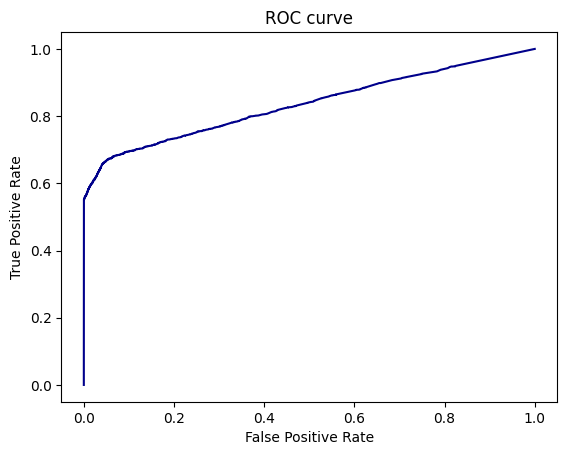

In [87]:
false_p,true_p,thresholds = roc_curve(y_test,1-prob_score)
plt.plot(false_p,true_p, color = 'darkblue')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [108]:
i = np.arange(len(false_p))
roc = DataFrame({'false_pos_rate' : Series(false_p, index=i),'true_pos_rate' : Series(true_p, index = i), '1-false_pos_rate' : Series(1-false_p, index = i), 
                    'tf' : Series(true_p - (1-false_p), index = i), 'thresholds' : Series(thresholds, index = i)})
roc.iloc[(roc['tf']-0).abs().argsort()[[0]]]

,false_pos_rate,true_pos_rate,1-false_pos_rate,tf,thresholds
1828,0.248794,0.751494,0.751206,0.000288,0.06


[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, '')]

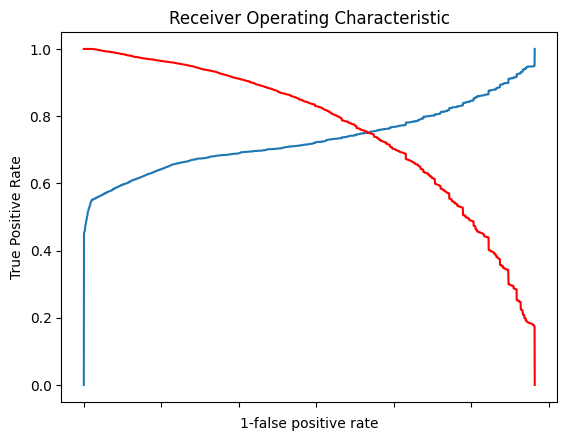

In [109]:
fig, ax = plt.subplots(1)
plt.plot(roc['true_pos_rate'])
plt.plot(roc['1-false_pos_rate'], color = 'red')
plt.xlabel('1-false positive rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
ax.set_xticklabels([])


In [120]:
#To find the optimal cutoff, we can maximize Youden's J statistic where J = TPR - FPR, 
#Hence, cutoff approx ~ 0.52

prob = clf_forest.predict_proba(X_test)[:,1]
prob[prob > 0.52] = 1
prob[prob <= 0.52] = 0

In [121]:
print(classification_report(y_test, prob))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     27155
           1       0.99      0.55      0.71      2845

    accuracy                           0.96     30000
   macro avg       0.97      0.78      0.84     30000
weighted avg       0.96      0.96      0.95     30000



All values here have remained the same as the previous model.

Since the client loses $8 for every incorrect transaction marked as fradulent, we minimize that risk considering we have 99% precision for all transactions identified as fradulent. However since our recall is only 55%, we might be missing some of the fradulent transactions. Overall, our model has 96% accuracy in identifying whether a transaction is fradulent, however that may be because majority of the data is labelled as non-fraduluent.